[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/tutorials/adaptive_substepping/adaptive_substepping.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/tutorials/adaptive_substepping/adaptive_substepping.ipynb)

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
from functools import partial
import timeit
import numpy as np, scipy
from scipy.optimize import elementwise
from matplotlib import pyplot
from collections import namedtuple
import numba

from open_atmos_jupyter_utils import show_plot
from PySDM import physics
from PySDM_examples.Grabowski_and_Pawlowska_2023.settings import DRY_SPECTRA
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.physics.dimensional_analysis import DimensionalAnalysis

In [3]:
n_sd=2**4 # TEMP 2**10
commons = {
    'kappa': 1.28,
    'init_temperature_K': 300,
    'init_dry_pressure_Pa': 100000,
    'total_water_mixing_ratio': 21.5/1000,
    't_max_s': 300, # TEMP!
}

dry_spectra = {
    aerosol: ConstantMultiplicity(DRY_SPECTRA[aerosol][commons['kappa']]).sample_deterministic(n_sd)
    for aerosol in DRY_SPECTRA
}

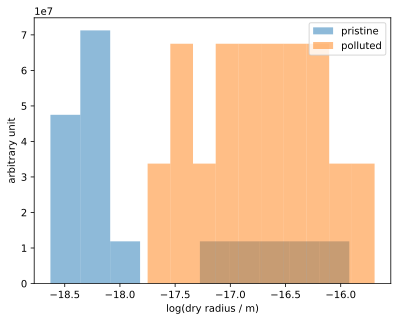

In [4]:
for aerosol, data in dry_spectra.items():
    pyplot.hist(np.log(data[0]), weights=data[1], density=False, label=aerosol, alpha=.5)
pyplot.gca().set(ylabel="arbitrary unit", xlabel="log(dry radius / m)")
pyplot.legend()
show_plot()


In [5]:
make_namedtuple = lambda name, items: namedtuple(name, items.keys())(*items.values())

ix = make_namedtuple("I", {
    "ln_rw": slice(0, n_sd),
    "pd": n_sd,
    "T": n_sd + 1,
    "size": n_sd + 2
})

In [6]:
formulae = make_namedtuple("F", {
    # eq. (1) in the NPG paper
    "dr_dt": lambda c, rw, rho_v, rho_o: c.D_eff / c.rho_w * (rho_v - rho_o) / rw,
    # eq. (4) in the NPG paper
    "RH_eq": lambda c, rw, rd: 1 + c.A / rw - c.κ * (rd / rw)**3,
    # eq. (13) in the NPG paper
    "dpd_dt": lambda c, rhod, w: -rhod * c.g * w,
    "dT_dt": lambda c, dpd_dt, dqv_dt, rhod: (dpd_dt / rhod - dqv_dt * c.l_v) / c.cp_d,
    # Bolton 1980 saturation vapour pressure formula (https://doi.org/10.1175/1520-0493(1980)108%3C1046:TCOEPT%3E2.0.CO;2)
    "pvs": lambda c, T: c.B80_G0 * np.exp((c.B80_G1 * (T - c.T0)) / ((T - c.T0) + c.B80_G2)),
    # trivia
    "rhod": lambda c, pd, T: pd / c.R_d / T,
    "rhov": lambda c, pv, T: pv / c.R_v / T,
    "RH": lambda c, rw3, rho_vs, rhod: rhod * (c.qt - np.dot(rw3, c.xi) / c.m_d * 4/3 * np.pi * c.rho_w) / rho_vs,
    "dqv_dt": lambda c, rw, drw_dt: -4 * np.pi * np.dot(c.xi * rw**2, drw_dt) / c.m_d * c.rho_w,
    "w": lambda c, t: c.w_mean * np.pi / 2 * np.sin(np.pi * t * c.w_mean / c.z_half),
    "z": lambda c, t: c.z_half / 2 * (1 - np.cos(np.pi * t * c.w_mean / c.z_half)),
    "r_c": lambda c, rd: (3 * c.κ * rd**3 / c.A)**.5,
})

In [7]:
import mendeleev
def constants(**kwargs):
    
    r_dry = kwargs['dry_spectrum'][0]
    multiplicities = kwargs['dry_spectrum'][1]
    
    SI = physics.si
    M_a = (
        0.78 * 2 * mendeleev.N.atomic_weight * SI.g / SI.mole + 
        0.21 * 2 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        0.01 * 1 * mendeleev.Ar.atomic_weight * SI.g / SI.mole
    )
    M_v = (
        1 * mendeleev.O.atomic_weight * SI.g / SI.mole + 
        2 * mendeleev.H.atomic_weight * SI.g / SI.mole
    )
    R_str = scipy.constants.R * SI.J / SI.K / SI.mole
    
    constants = make_namedtuple("C", {
        "R_d": R_str / M_a,
        "R_v": R_str / M_v,
        "cp_d": 1000 * SI.J / SI.kg / SI.K,
        "l_v": 45000 * SI.joule / SI.mol / M_v,
        "g": scipy.constants.g * SI.m / SI.s**2,
        "A": 1e-3 * SI.um,
        "rho_w": 1 * SI.kg / SI.litre,
        "D_eff": 2.3e-5 * SI.metre**2 / SI.s,
        "T0": scipy.constants.zero_Celsius * SI.K,

        "B80_G0": 6.112 * SI.hPa,
        "B80_G1": 17.67 * SI.dimensionless,
        "B80_G2": 243.5 * SI.K,
        
        "κ": kwargs['kappa'],
        "r_d": r_dry * SI.m,
        "xi": multiplicities,
        "m_d": 1 * SI.kg,
        "qt": kwargs['total_water_mixing_ratio'],
        "t_max": kwargs['t_max_s'] * SI.s,
        "w_mean": kwargs['w_multiplier'] * SI.m / SI.s,
        "z_half": 150 * SI.m #TODO
    })
    return constants, SI

def initial_condition(SI, r_dry, const, init_dry_pressure_Pa, init_temperature_K,):
    RH = formulae.RH(const,
                 rw3=np.zeros_like(r_dry),
                 rho_vs=formulae.rhov(const, pv=formulae.pvs(const, init_temperature_K), T=init_temperature_K),
                 rhod=formulae.rhod(const, pd=init_dry_pressure_Pa, T=init_temperature_K)
                )
    result = elementwise.find_root(lambda r_wet, r_dry: RH - formulae.RH_eq(const, r_wet, r_dry), (r_dry, 1e3 * r_dry), args=(r_dry,))
    assert all(result.success)

    y0 = [0] * ix.size
    y0[ix.pd] = init_dry_pressure_Pa * SI.Pa
    y0[ix.T] = init_temperature_K * SI.K
    y0[ix.ln_rw] = np.log(result.x)
    
    return y0

In [8]:
jit_compile = numba.jit(error_model='numpy', fastmath=True)
jf = make_namedtuple("J", {k: jit_compile(v) for k, v in formulae._asdict().items()})

@jit_compile
def ode_rhs(t, y, c):
    rhod = jf.rhod(c, pd=y[ix.pd], T=y[ix.T])
    rho_vs = jf.rhov(c, pv=jf.pvs(c, y[ix.T]), T=y[ix.T])
    rw = np.exp(y[ix.ln_rw])
    RH = jf.RH(c, rw3=rw**3, rho_vs=rho_vs, rhod=rhod)
    RH_eq = jf.RH_eq(c, rw=rw, rd=c.r_d)
    
    dy_dt = np.empty_like(y)
    dy_dt[ix.pd] = jf.dpd_dt(c, rhod=rhod, w=jf.w(c, t))
    dy_dt[ix.ln_rw] = jf.dr_dt(c, rw=rw, rho_v=RH * rho_vs, rho_o=RH_eq * rho_vs) / rw
    dy_dt[ix.T] = jf.dT_dt(c, dpd_dt=dy_dt[ix.pd], dqv_dt=jf.dqv_dt(c, rw=rw, drw_dt=dy_dt[ix.ln_rw] * rw), rhod=rhod)
    return dy_dt

In [9]:
@jit_compile
def solve(y, nt, dt, fun, args):
    for step in range(1, nt + 1):
        y[:, step] = y[:, step - 1] + dt * fun(step * dt, y[:, step - 1], *args)
    return y

def explicit_euler(*, fun, t_span, y0, min_step, max_step, args):
    dt = min_step
    nt = int((t_span[1] - t_span[0]) / dt)
    y = np.empty(shape=(len(y0), nt + 1))
    y[:, 0] = y0
    return make_namedtuple(
        "Solution", {
        'success': True,
        'message': '',
        'y': solve(y, nt, dt, fun, args),
        't': np.linspace(t_span[0], t_span[1], nt+1, endpoint=True)
        })

In [10]:
def run(dry_spectra, w_multiplier, eps):
    solutions = {}
    times = {}
    for aerosol, dry_spectrum in dry_spectra.items():
        c, SI = constants(dry_spectrum=dry_spectrum, w_multiplier=w_multiplier, **commons)
        y0 = initial_condition(SI, dry_spectrum[0], const=c, init_dry_pressure_Pa=commons['init_dry_pressure_Pa'], init_temperature_K=commons['init_temperature_K'])
        for key, solver in {
            # f"{aerosol}-EULER" : partial(explicit_euler, min_step=.5 * SI.s),
            f"{aerosol}-LSODA" : partial(scipy.integrate.solve_ivp, method='LSODA', atol=eps),
        }.items():
            solution = [None]
            def do(solution):
                solution[0] = solver(
                    fun=ode_rhs, 
                    t_span=(0, c.t_max / w_multiplier),
                    y0=y0,
                    max_step=.5 * SI.s,
                    args=(c,),
                )
                assert solution[0].success, solution[0].message
            timer = timeit.Timer(partial(do, solution=solution))
            timer.timeit(number=1) # warmup (JIT, caches, ...)
            times[key] = timer.timeit(number=1)
            solutions[key]=solution[0]
    return solutions, times

In [11]:
velocities_multiplier = (1, 0.5, 0.002)
all_solutions = {}
all_times = {}
for w_idx, w_val in enumerate(velocities_multiplier):
    solutions_w, times_w = run(dry_spectra, w_multiplier=w_val, eps=1e-3)
    for key, solution in solutions_w.items():
        all_solutions[(w_idx, key)] = solution
        all_times[(w_idx, key)] = times_w[key]

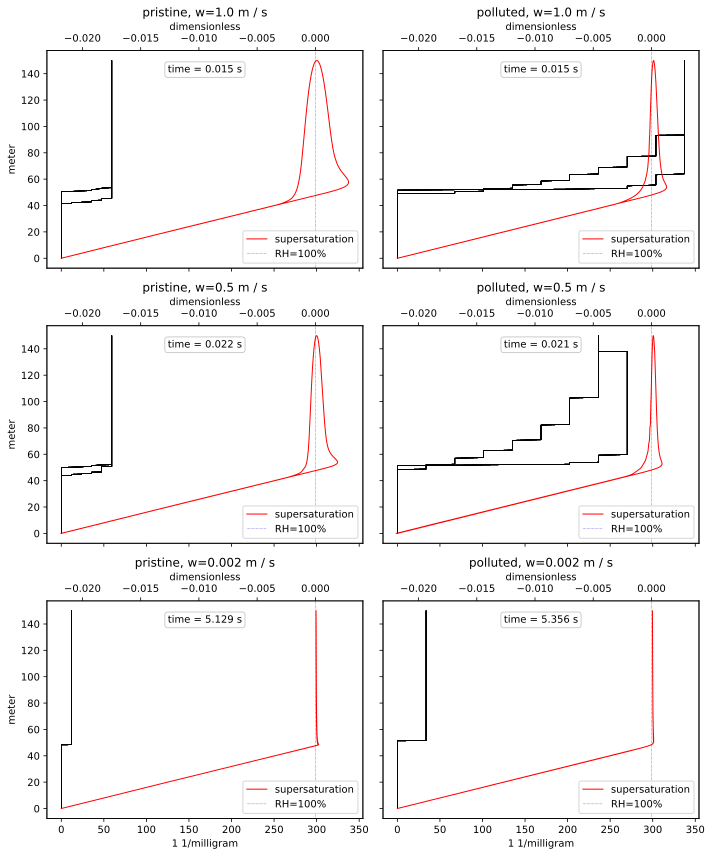

In [12]:
rows = []
for w_idx, w_val in enumerate(velocities_multiplier):
    row_keys = [f"w{w_idx}-{aerosol}" for aerosol in dry_spectra.keys()]
    rows.append(row_keys)

fig, axs = pyplot.subplot_mosaic(
    rows,
    sharey=True,
    sharex=True,
    figsize=(10, 4*len(velocities_multiplier)),
    tight_layout=True,
)
twin_prev = None
for w_idx, w_multiplier in enumerate(velocities_multiplier):
    for aerosol in dry_spectra.keys():
        key = f"w{w_idx}-{aerosol}"
        solution_key = [k for k in all_solutions.keys() if k[0] == w_idx and k[1].startswith(aerosol)][0]
        solution = all_solutions[solution_key]
        time = all_times[solution_key]

        twin = axs[key].twiny()
        
        with DimensionalAnalysis():
            c, SI = constants(
                dry_spectrum=dry_spectra[aerosol],
                kappa=commons['kappa'],
                total_water_mixing_ratio=commons['total_water_mixing_ratio'],
                t_max_s=commons['t_max_s'],
                w_multiplier=w_multiplier,
            )
            SI.setup_matplotlib()

            t = solution.t * SI.s
            pd = solution.y[ix.pd] * SI.Pa
            T = solution.y[ix.T] * SI.K
            rw = np.exp(solution.y[ix.ln_rw]) * SI.m
            RH = formulae.RH(
                c,
                rw3=rw.T**3,
                rho_vs=formulae.rhov(c, pv=formulae.pvs(c, T), T=T),
                rhod=formulae.rhod(c, pd=pd, T=T)
            )
            twin.plot(RH - 1, formulae.z(c, t), color='red', linewidth=1, label="supersaturation")
            twin.axvline(0, linestyle=':', color='blue', linewidth=0.5, label="RH=100%")
            twin.legend(loc='lower right')
            if twin_prev:
                twin.sharex(twin_prev)
            axs[key].set_title(f"{aerosol}, w={c.w_mean:~}")

            for i in range(ix.ln_rw.start, ix.ln_rw.stop):
                axs[key].plot(np.sum(np.where(rw.T > formulae.r_c(c, c.r_d), c.xi, 0), axis=1) / c.m_d, formulae.z(c, t), color='k', linewidth=0.5)
            axs[key].xaxis.set_units(1/SI.mg)
            twin_prev = twin
            axs[key].annotate(
                f"time = {np.mean(time):.3f} s",
                xy=(0.5, 0.90),
                xycoords="axes fraction",
                ha="center",
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    fc="white",
                    ec="0.8",
                    lw=1,
                )
            )
                        

TODO:
- adaptive ODE solver
- plots for different tolerances
- color-scale dt_adapt
- tolerances in SciPy solver
- comparison for different size attributes (time efficiency, accuracy)

IDEAS:
- Jacobian
- isotopes